In [45]:
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt 
import  pickle


import sys 
sys.path.append('../code_general_Finkelsteinlab/')
import Process_SeqLibrary_Finkelsteinlab as preprocess
reload(preprocess);
import plotting_Finkelsteinlab as pltData
reload(pltData);


sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA 

from scipy.optimize import curve_fit

In [2]:
data = pickle.load(open('E-dCas9-sequence-cluster-IntensityAtConcentration.txt'))

In [3]:
datadict = dict(data)

In [41]:
def collect_all_clusters(CHAMP_data, concentrations, target_seq, Cas):
    '''
    returns a dataframe with every row being a single cluster. 
    Hence, every sequence is repeated as there are multiple clusters with the same sequence
    
    
    Can be used later to get the median binding curve
    '''
    Seq = []
    c1 = []
    c2 = []
    c3 = []
    c4 = []
    c5 = []
    c6 = []
    c7 = []
    c8 = []
    
    for sequence in datadict.keys():
        for cluster , curve in enumerate(datadict[sequence]):
            Seq.append(sequence)
            c1.append(curve[0]) 
            c2.append(curve[1]) 
            c3.append(curve[2]) 
            c4.append(curve[3]) 
            c5.append(curve[4]) 
            c6.append(curve[5]) 
            c7.append(curve[6]) 
            c8.append(curve[7]) 
    
    df = pd.DataFrame()
    df['sequence'] = Seq
    df[str(concentrations[0]) + 'nM'] = c1
    df[str(concentrations[1]) + 'nM'] = c2
    df[str(concentrations[2]) + 'nM'] = c3
    df[str(concentrations[3]) + 'nM'] = c4
    df[str(concentrations[4]) + 'nM'] = c5
    df[str(concentrations[5]) + 'nM'] = c6
    df[str(concentrations[6]) + 'nM'] = c7
    df[str(concentrations[7]) + 'nM'] = c8
    
    
    # find on-target, canonical PAM , etc. 
    df['On Target'] = df['sequence'].apply(lambda S: Finkellib.find_ontarget(S, target_seq, Cas))
    df['PAM'] = df['sequence'].apply(lambda S: Finkellib.separate_PAM(S, Cas)[0])
    df['Canonical'] = df['sequence'].apply(lambda S: Finkellib.separate_PAM(S, Cas)[2])
    return df


def substract_background(df, concentrations):
    background = df[str(concentrations[0]) + 'nM'].copy()
    for c in concentrations:
        df[str(c) + 'nM'] = df[str(c) + 'nM'] - background
    return df


def find_saturation(df, concentrations):
    OnTarget = df[df['On Target'] & df['Canonical'] ].copy()
    saturation_value = OnTarget[str(concentrations[-1])+'nM'].median()
    return saturation_value


def row_to_list(row, concentrations):
    binding_curve = []
    for c in concentrations:
        binding_curve.append( row[str(c)+'nM']  )
    return np.array(binding_curve)
    

def get_binding_curves(df, concentrations):
    '''
    get the equivalent of bound fraction:
        (I(c) - Imin )/(Imax - Imin)
    with 
    * I(c) the fluoresence intensity at concentration c, 
    * Imin the background fluoresence determined seperately for every cluster
    * Imax the value the on-target attains at saturation (determined based on median over clusters) 
    '''
    
    # remove the clusters for which there is not a complete binding curve available:
    df.dropna(axis=0,inplace=True)
    

    no_Imin = substract_background(df, concentrations)
    PreMedian = no_Imin.drop(['On Target','PAM','Canonical'],axis=1).copy()   
    Medians = PreMedian.groupby('sequence').median(skipna=True) 
    Imax = find_saturation(df,concentrations)
    
    binding_curves = []
    for i in range(len(Medians)):
        binding_curves.append( row_to_list(Medians.iloc[i], concentrations)/Imax )
    Medians['binding_curves'] = binding_curves
    return Medians 


def Hill_eq(C, Kd):
    return (1.0+Kd/C)**(-1)

def get_ABA(df, concentrations):
    df['ABA'] = df['binding_curves'].apply(lambda x: np.log(curve_fit(Hill_eq, concentrations,x)[0][0]) )
    return df 


def bootstrap_ABA(grouped,  nmbr_runs,Imax, concentrations):
    bstrp_ABA = []
    for run in range(nmbr_runs):
        # --- bootstrap sample cluster (per given sequence) ----- 
        bstrp_sample = grouped.sample(n=len(grouped),replace=True)
        
        # --- get our new 'median' binding curve ----
        bstrp_med = bstrp_sample.median()
        bstrp_binding_curve = row_to_list(bstrp_med, concentrations)/Imax
    
        # --- calculate ABA --- 
        bstrp_ABA.append( np.log(curve_fit(Hill_eq, concentrations[1:], bstrp_binding_curve[1:])[0][0] ) )
        
    bstrp_ABA = np.array(bstrp_ABA)
    return np.mean(bstrp_ABA), np.std(bstrp_ABA), bstrp_sample




def build_dataframe_for_fitting( full_data,  nmbr_boot, concentrations ):
    # remove the clusters for which there is not a complete binding curve available:
    full_data.dropna(axis=0,inplace=True)
    
    # --- substract background ---- 
    minus_Imin = substract_background(full_data, concentrations)
    
    # --- saturation level (to convert into bound fraction) ----
    Imax = find_saturation(full_data,concentrations)
    
    # --- for every sequence: use bootstrapping to find avg. ABA and errorbar ABA ---- 
    sequences = []
    ABA = []
    error = []
    
    
    all_seqs = minus_Imin.drop(['On Target','PAM','Canonical'],axis=1).copy() 

    for name,group in all_seqs.groupby('sequence'):
        # --- perform bootstrapping on ABA values for this sequence  ----
        avg, std, bstrp_sample = bootstrap_ABA(group,nmbr_boot, Imax ,concentrations  )
        
        # --- store results into processed dataframe ---- 
        sequences.append(name)
        ABA.append(avg)
        error.append(std)
        
    # --- stroe results into processed dataframe ---- 
    processed_data = pd.DataFrame()
    processed_data['sequence'] = sequences
    processed_data['ABA'] = ABA
    processed_data['error'] = error
    print len(bstrp_sample)
    
    return processed_data

def dataframe_with_concentration(full_data):
    full_data.dropna(axis=0,inplace=True)
    minus_Imin = substract_background(full_data, concentrations)
    Imax = find_saturation(full_data,concentrations)
    all_seqs = minus_Imin.drop(['On Target','PAM','Canonical'],axis=1)
    Medians = all_seqs.groupby('sequence').median(skipna=True)
    binding_curves = []
    for i in range(len(Medians)):
        binding_curves.append( row_to_list(Medians.iloc[i], concentrations)/Imax )
    Medians['binding_curves'] = binding_curves
    processed_data = get_ABA(Medians, concentrations)
    c_list = map(lambda x: str(x) + 'nM', concentrations)
    processed_data[c_list] = processed_data[c_list]/Imax
    processed_data.drop(['binding_curves', c_list[0]], inplace=True, axis=1) 
    processed_data.reset_index(inplace=True)
    return processed_data

In [5]:
concentrations = [0.1, 0.3, 1, 3, 10, 30, 100, 300]
target_E = 'TTTAGACGCATAAAGATGAGACGCTGG'
Cas = 'Cas9'

df = collect_all_clusters(CHAMP_data=datadict,
                          concentrations=concentrations, 
                          target_seq=target_E, 
                          Cas=Cas)

In [ ]:
processed_data = build_dataframe_for_fitting(df, nmbr_boot=100,concentrations=concentrations)

In [ ]:
processed_data.to_csv('./TargetE-dCas9_AbsoluteABA_raw.csv', index=False)

### Including the concentrations

In [42]:
processed_data = dataframe_with_concentration(df)

In [43]:
processed_data.to_csv('./TargetE-dCas9_AbsoluteABA_with_concentrations.csv', index=False)

In [44]:
processed_data.head()

,sequence,0.3nM,1nM,3nM,10nM,30nM,100nM,300nM,ABA
0,AAAAGACGCATAAAGATGAGACGCTGG,0.042315,0.098464,0.147735,0.517823,0.719215,0.779476,1.025132,2.472665
1,AAATCACGCATAAAGATGAGACGCTGG,0.033915,0.069671,0.140017,0.505289,0.749726,0.796275,1.040612,2.461025
2,AAATCTCGCATAAAGATGAGACGCTGG,0.034964,0.054619,0.106636,0.466928,0.710597,0.768615,1.013939,2.648707
3,AAATCTGCCATAAAGATGAGACGCTGG,0.028400,0.038526,0.051516,0.398491,0.680187,0.775856,0.990754,2.863859
4,AAATCTGCGATAAAGATGAGACGCTGG,0.027610,0.022130,0.022363,0.312833,0.623188,0.706106,0.943954,3.199845


In [47]:
ABA_data = preprocess.process_Finkelstein_Library(processed_data, target_E, 'sequence', ['ABA'], 'Cas9', 
                                                  Canonical_PAM = True, Mut_type = ['OT','r'], Mut_min = 0, Mut_max = 20,
                                                  out_file_name = 'data.csv', out_path = './', nofilter = True,
                                                  save_data = False)


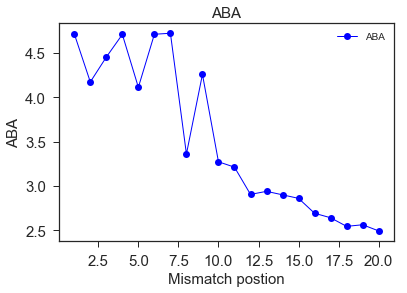

In [50]:
_= pltData._= pltData.plot_single_mut_data(ABA_data, 'ABA', 'r', Canonical=True, data_name='ABA', Plot=True, logplot=False,
                         SaveFigures=False, figure_name='./Figure.pdf')

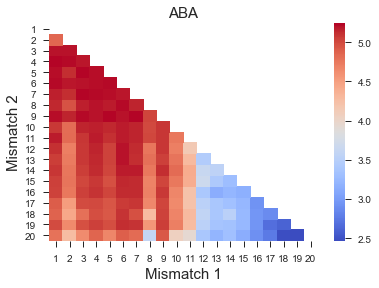

In [51]:
_,_ = pltData.plot_double_mut_data(ABA_data, 'ABA', 'r', Canonical=True, Ng=20, data_name='ABA', Plot=True, logplot=False,
                        SaveFigures=False, figure_name='./Figure.pdf')

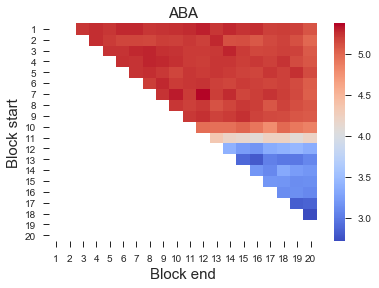

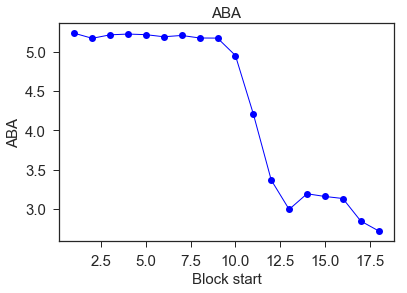

In [52]:
_,_,_ = pltData.plot_block_mm_data(ABA_data, 'ABA', data_name='ABA', Canonical=True, Ng=20, Plot=True, logplot=False,
                        SaveFigures=False, figure_names=['./Figure1.pdf','./Figure2.pdf'])